## Setup environment

First, install neccessary requirements.
It is highly recommended to use a clean virtual environment, as well as to have a 24 GB CUDA-capable GPU.
This notebook was created on a machine with an Nvidia GeForce RTX 4090, although some other instances were run on an Nvidia A10.
If you don't have a 24 GB card, [Lambda Labs GPU Cloud](https://lambdalabs.com/service/gpu-cloud) offers spot A10 instances for $0.60/hour!

##### Windows only

On Windows you may need to explicitly install the CUDA-enabled version of [torch](https://pytorch.org/get-started/locally/).

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

### Install requirements

In [2]:
!pip install -q -r ./requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


You will also need to have have either `avconv` or `ffmpeg` in your `PATH` as described in the [pydub README](https://github.com/jiaaro/pydub#getting-ffmpeg-set-up).

#### Linux

In [ ]:
!apt-get install libav-tools libavcodec-extra

#### Mac

In [ ]:
!brew install libav

#### Windows

Download an FFmpeg release (for example, from [here](https://www.gyan.dev/ffmpeg/builds/)) and place the `bin/` folder in your `PATH`.

## Prepare data

Generating a literAI podcast takes five steps, plus an optional sixth step to upload the resulting output.
To illustrate, we'll run each of these steps separately, although they can be run all as one by invoking `python -m literai`.

We'll be generating a podcast for "The War of the Worlds" by H. G. Wells.
The first thing to do is download the raw UTF-8 text from [Project Gutenberg](https://www.gutenberg.org/ebooks/36).

In [3]:
!curl https://www.gutenberg.org/cache/epub/36/pg36.txt > the-war-of-the-worlds.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  357k  100  357k    0     0   951k      0 --:--:-- --:--:-- --:--:--  954k


Project Gutenberg files contain some extra text at the beginning/end of the file we need to clean out.
Thankfully, it's very clearly delineated.

In [5]:
START_MARKER = "*** START OF THE PROJECT GUTENBERG EBOOK THE WAR OF THE WORLDS ***"
END_MARKER = "*** END OF THE PROJECT GUTENBERG EBOOK THE WAR OF THE WORLDS ***"
text = open("the-war-of-the-worlds.txt", "r", encoding="utf-8").read()
open("the-war-of-the-worlds.txt", "w", encoding="utf-8").write(text[text.find(START_MARKER)+len(START_MARKER):text.find(END_MARKER)])

337437

## Generate summaries

The first step of literAI is to generate summaries using [pszemraj/long-t5-tglobal-xl-16384-book-summary](https://huggingface.co/pszemraj/long-t5-tglobal-xl-16384-book-summary).
Two sets of summaries are created: one with a target token output length of 512 used as context to the conversation LLM, and one with a target token output length of 256 which is repeated periodically throughout the podcast to remind the listener of the events of the novel.

In [6]:
!python -m literai.steps.step1 "The War of the Worlds" the-war-of-the-worlds.txt

------------- STEP 1 (Summarize text) ------------- 



Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
01/31/2023 11:25:46 INFO Loaded model pszemraj/long-t5-tglobal-xl-16384-book-summary to cuda

Generating Summaries: 100%|██████████| 43/43 [08:48<00:00, 12.29s/it]

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]
01/31/2023 11:34:48 INFO Loaded model pszemraj/long-t5-tglobal-xl-16384-book-summary to cuda

Generating Summaries: 100%|██████████| 43/43 [05:17<00:00,  7.39s/it]


In [8]:
open("output/the-war-of-the-worlds/summaries/summary-2048-512.txt", "r", encoding="utf-8").readlines()[0:2]

['The first book of the War of the Worlds is entitled, "The Coming of the Martians," and it begins with a prologue by H. G. Wells in which he asks who will dwell in these worlds if they are inhabited. He then proceeds to tell the story of his voyage to the red planet. In this first book, Wells covers the entire history of the war from the point of view of the Martians.\n',
 '\tThat night, Ogilvy takes David up to his observatory to look at the progress of the Martian missiles. They see a pinprick of light on the surface of the red planet and another shooting star. Over the next ten nights, there are more and more signs that the Martians are preparing to attack. One night, David and his wife go for a walk and look at the stars. They see a bright dot of light creeping zenithward toward Mars. Then there is the first "falling star," which is described as a line of flame high in the atmosphere. David is at home writing in his study when it happens. Many people must have seen it, and taken i

## Generate script

Next, we generate the actual script for the podcast using [allenai/cosmo-xl](https://huggingface.co/allenai/cosmo-xl), a very interesting LLM that could be said to be the "heart" of literAI.

In [9]:
!python -m literai.steps.step2 "The War of the Worlds" "H. G. Wells"


Part:   0%|          | 0/2 [00:00<?, ?it/s]

Section:   0%|          | 0/20 [00:00<?, ?it/s]


Passage:   0%|          | 0/1 [00:00<?, ?it/s]



Dialogue:   0%|          | 0/4 [00:00<?, ?it/s]



Dialogue:  25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]



Dialogue:  50%|█████     | 2/4 [00:07<00:07,  3.51s/it]



Dialogue:  75%|███████▌  | 3/4 [00:10<00:03,  3.40s/it]



Dialogue: 100%|██████████| 4/4 [00:12<00:00,  2.95s/it]



                                                       


Passage: 100%|██████████| 1/1 [00:12<00:00, 12.60s/it]


                                                      

Section:   5%|▌         | 1/20 [00:12<03:59, 12.61s/it]


Passage:   0%|          | 0/1 [00:00<?, ?it/s]



Dialogue:   0%|          | 0/4 [00:00<?, ?it/s]



Dialogue:  25%|██▌       | 1/4 [00:00<00:02,  1.18it/s]



Dialogue:  50%|█████     | 2/4 [00:01<00:01,  1.13it/s]



Dialogue:  75%|███████▌  | 3/4 [00:02<00:00,  1.29it/s]



Dialogue: 100%|██████████| 4/4 [00:03<00:00,  1.38it/s]



 

------------- STEP 2 (Write scripts) ------------- 


In [10]:
open("output/the-war-of-the-worlds/scripts/part1.txt", "r", encoding="utf-8").readlines()[63:65]

['Alice: You make a valid point about the character of David being unable to see the common because the soldiers have taken over. What do you think is happening here with David?\n',
 "Bob: Well, it seems to me that David is feeling a bit hopeless and helpless. He sees the common and it looks like the Martians have taken over, but he doesn't understand why they're doing this. It makes him feel like there's no way they'll be able to win this war.\n"]

## Generate image descriptions

To generate the image descriptions used to prompt the Stable Diffusion models, we use the instruction tuned version of Google's T5 LLM, [google/flan-t5-xl](https://huggingface.co/google/flan-t5-xl) with a five-shot prompt of scenes from books and corresponding prompts for Stable Diffusion models.

In [15]:
from literai.images import DESCRIBE_PROMPT
DESCRIBE_PROMPT.split('\n')[0:2]

['passage: There was certainly too much of it in the air. Even the Duchess sneezed occasionally; and as for the baby, it was sneezing and howling alternately without a moment\'s pause. The only things in the kitchen that did not sneeze, were the cook, and a large cat which was sitting on the hearth and grinning from ear to ear. "Please would you tell me," said Alice, a little timidly, for she was not quite sure whether it was good manners for her to speak first, "why your cat grins like that?" "It\'s a Cheshire cat," said the Duchess, "and that\'s why. Pig!"',
 'scene: a kitchen filled with sneezing people, a large cat sitting on the hearth and grinning from ear to ear']

In [11]:
!python -m literai.steps.step3 "The War of the Worlds" the-war-of-the-worlds.txt


Part:   0%|          | 0/2 [00:00<?, ?it/s]

Summary:   0%|          | 0/20 [00:00<?, ?it/s]


Batch:   0%|          | 0/9 [00:00<?, ?it/s]


Batch:  11%|█         | 1/9 [00:01<00:15,  1.92s/it]


Batch:  22%|██▏       | 2/9 [00:02<00:09,  1.39s/it]


Batch:  33%|███▎      | 3/9 [00:03<00:07,  1.22s/it]


Batch:  44%|████▍     | 4/9 [00:04<00:05,  1.09s/it]


Batch:  56%|█████▌    | 5/9 [00:05<00:04,  1.06s/it]


Batch:  67%|██████▋   | 6/9 [00:06<00:03,  1.03s/it]


Batch:  78%|███████▊  | 7/9 [00:07<00:01,  1.08it/s]


Batch:  89%|████████▉ | 8/9 [00:08<00:00,  1.04it/s]


Batch: 100%|██████████| 9/9 [00:09<00:00,  1.03it/s]


                                                    

Summary:   5%|▌         | 1/20 [00:09<03:01,  9.58s/it]


Batch:   0%|          | 0/9 [00:00<?, ?it/s]


Batch:  11%|█         | 1/9 [00:00<00:06,  1.32it/s]


Batch:  22%|██▏       | 2/9 [00:01<00:05,  1.38it/s]


Batch:  33%|███▎      | 3/9 [00:02<00:05,  1.18it/s]


Batch:  44%|████▍     | 4/9 [00:03<00:

------------- STEP 3 (Make image descriptions) ------------- 


## Generate images

Actual image generation uses [dreamlike-art/dreamlike-diffusion-1.0](dreamlike-art/dreamlike-diffusion-1.0), a fine-tuned version of Stable Diffusion 1.5.

In [12]:
!python -m literai.steps.step4 "The War of the Worlds"

------------- STEP 4 (Draw images) ------------- 



Fetching 13 files: 100%|██████████| 13/13 [00:00<?, ?it/s]

Part:   0%|          | 0/2 [00:00<?, ?it/s]

Image:   0%|          | 0/12 [00:00<?, ?it/s]

Image:   8%|▊         | 1/12 [00:10<01:53, 10.31s/it]

Image:  17%|█▋        | 2/12 [00:18<01:32,  9.26s/it]

Image:  25%|██▌       | 3/12 [00:27<01:19,  8.86s/it]

Image:  33%|███▎      | 4/12 [00:35<01:09,  8.67s/it]

Image:  42%|████▏     | 5/12 [00:43<00:59,  8.57s/it]

Image:  50%|█████     | 6/12 [00:52<00:51,  8.51s/it]

Image:  58%|█████▊    | 7/12 [01:00<00:42,  8.46s/it]

Image:  67%|██████▋   | 8/12 [01:09<00:33,  8.43s/it]

Image:  75%|███████▌  | 9/12 [01:17<00:25,  8.41s/it]

Image:  83%|████████▎ | 10/12 [01:25<00:16,  8.39s/it]

Image:  92%|█████████▏| 11/12 [01:34<00:08,  8.38s/it]

Image: 100%|██████████| 12/12 [01:42<00:00,  8.38s/it]

                                                      

Summary:   0%|          | 0/20 [00:00<?, ?it/s]


Description:   0%|          | 0/9 [00:00<?, ?it/s]



Image:   0%|          | 

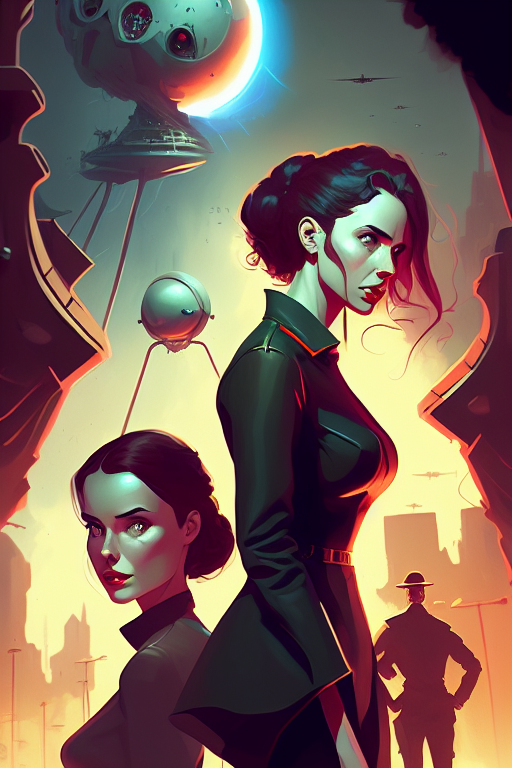

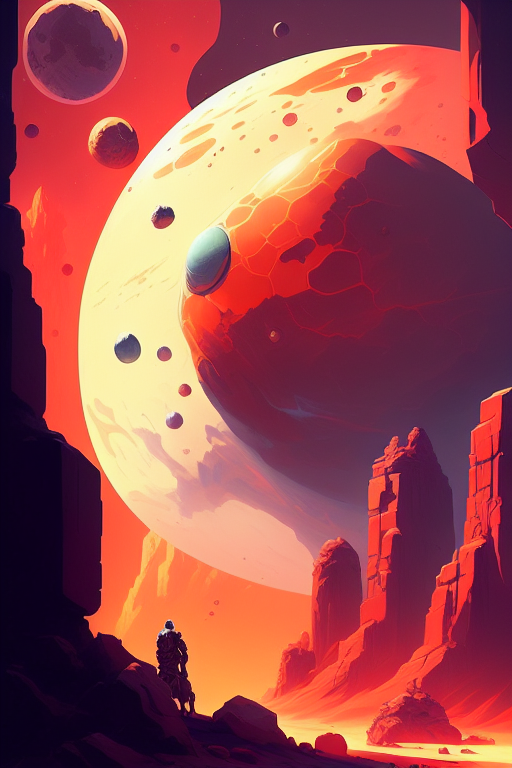

In [18]:
from IPython.display import Image, display
display(Image(filename="output/the-war-of-the-worlds/images/part1-title-9.png"))
display(Image(filename="output/the-war-of-the-worlds/images/part1-1-3-0.png"))

## Generate audio

To generate audio from the podcast script we use [TorToiSe](https://github.com/neonbjb/tortoise-tts), which uses several purpose-trained models to mimic voices from a few audio samples.
We will use two of the provided training voices, although this can be custmoized via command-line arguments.
This step takes the most amount of time by a wide margin, and so it is left for last.
Beware, this will take a while!

In [2]:
!python -m literai.steps.step5 "The War of the Worlds"

------------- STEP 5 (Record audio) ------------- 



Part:   0%|          | 0/2 [00:00<?, ?it/s]

Line:   0%|          | 0/171 [00:00<?, ?it/s]

Line:   1%|          | 1/171 [02:07<6:00:35, 127.27s/it]

Line:   1%|          | 2/171 [03:15<4:20:20, 92.43s/it] 

Line:   2%|▏         | 3/171 [06:00<5:52:03, 125.74s/it]

Line:   2%|▏         | 4/171 [08:33<6:19:17, 136.28s/it]

Line:   3%|▎         | 5/171 [09:33<5:01:22, 108.93s/it]

Line:   4%|▎         | 6/171 [13:44<7:12:45, 157.37s/it]

Line:   4%|▍         | 7/171 [16:33<7:20:16, 161.08s/it]

Line:   5%|▍         | 8/171 [18:49<6:55:42, 153.02s/it]

Line:   5%|▌         | 9/171 [25:21<10:14:55, 227.75s/it]

Line:   6%|▌         | 10/171 [28:38<9:45:33, 218.22s/it]

Line:   6%|▋         | 11/171 [33:29<10:41:40, 240.63s/it]

Line:   7%|▋         | 12/171 [35:55<9:20:43, 211.59s/it] 

Line:   8%|▊         | 13/171 [39:07<9:02:05, 205.86s/it]

Line:   8%|▊         | 14/171 [40:38<7:28:05, 171.25s/it]

Line:   9%|▉         | 15/171 [41:21<5:44:39, 132.56s/it]

Line:   9%|▉         | 16/17

In [4]:
from pydub import AudioSegment
from IPython.display import Audio
AudioSegment.from_mp3("output/the-war-of-the-worlds/recorded/part1.mp3")[4*60*1000:(4*60+15)*1000].export("output/clip.wav", format="wav") # 4:00-4:15
Audio("output/clip.wav")


## Finalize and upload (optional)

The last step is to add our podcast to an index of everything we've generated (`index.json`) which can be used in a front-end, as well as to upload all the data somewhere.
This is strictly optional -- `output/` has all the generated files available.
There is built-in support for updating the index and uploading to a Google Cloud Storage bucket.
If you would like to do this, make sure `google-cloud-storage` is installed.

In [5]:
!pip install -q google-cloud-storage


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Simply pass in the JSON service account credentials as well as the name of the Google Cloud Storage bucket.

In [8]:
!python -m literai.steps.step6 "The War of the Worlds" "H. G. Wells" --gcloud_credentials service_account.json --gcloud_bucket literai

------------- STEP 6 (Finalize) ------------- 



Upload: 100%|██████████| 412/412 [02:55<00:00,  2.35it/s]


## Conclusion

All done! Enjoy your open source AI generated podcast!

The output from this notebook can be viewed here: [https://literai.hooloovoo.ai/the-war-of-the-worlds](https://literai.hooloovoo.ai/the-war-of-the-worlds)